# Readability Assessment through Recurrent Neural Network

Readability assessment is a well known problem in natural language processing field. Giving someone the suitable text for his level of comprehension (not so easy and not so hard) could maximize his understanding and enjoyment. In this notebook we are trying to assess the readability of a given text regardless of the text subject using recurrent neural network.

## Corpus
> OneStopEnglish corpus: A new corpus for automatic readability assessment and text simplification  
> Sowmya Vajjala and Ivana Lučić  
> 2018  
> Proceedings of the Thirteenth Workshop on Innovative Use of NLP for Building Educational Applications, pages 297–304. Association for Computational Linguistics.  
> [url](http://aclweb.org/anthology/W18-0535). [bib file](https://aclanthology.coli.uni-saarland.de/papers/W18-0535/w18-0535.bib)

Please cite the above paper if you use this corpus in your research.

[![DOI](https://zenodo.org/badge/128919409.svg)](https://zenodo.org/badge/latestdoi/128919409)

<a rel="license" href="http://creativecommons.org/licenses/by-sa/4.0/"><img alt="Creative Commons License" style="border-width:0" src="https://i.creativecommons.org/l/by-sa/4.0/88x31.png" /></a><br />This work is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by-sa/4.0/">Creative Commons Attribution-ShareAlike 4.0 International License</a>.

Now let's dive into our corpus.

In [1]:
import sys
sys.path.append("/home/ms10596/PycharmProjects/match")
from ipywidgets import interact
from tabulate import tabulate
from IPython.display import display, HTML

from utils.loading import load_glove_embeddings
from utils.one_stop_english import load_corpus, corpus_to_words, corpus_to_pos, detokenize

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Flatten, Dense, LSTM, Bidirectional
import numpy as np

glove = load_glove_embeddings()
corpus = load_corpus()
articles, tags = corpus_to_words(corpus)

Reading level|Avg. Num. Words|Std. Dev|Number of Articles
---|---|---|---
Elementary|533.17|103.79|189
Intermediate|676.59|117.15|189
Advanced|820.49|162.52|189



In [3]:
@interact
def show_articles(i=(0,188,1), words=(0,1000,1)):
    data = [
        ["Advanced",detokenize(articles[i][:words])], 
        ["Intermediate",detokenize(articles[i+2][:words])], 
        ["Elementary",detokenize(articles[i+1][:words])]
    ]
    headers = ['Reading Level', 'Example']
    display(HTML(tabulate(data,tablefmt='html', headers=headers)+"<style>th,td {font-size: 10px}</style>"))

interactive(children=(IntSlider(value=94, description='i', max=188), IntSlider(value=500, description='words',…

In [15]:
articles, tags = corpus_to_pos(corpus)
tokenizer = Tokenizer(num_words=45)
tokenizer.fit_on_texts(articles)
print(tokenizer.word_index)
print(len(tokenizer.word_index))


{'nn': 1, 'in': 2, 'dt': 3, 'jj': 4, 'nns': 5, 'nnp': 6, ',': 7, '.': 8, 'rb': 9, 'prp': 10, 'vb': 11, 'vbd': 12, 'cc': 13, 'vbz': 14, 'to': 15, 'vbp': 16, 'cd': 17, 'vbn': 18, 'vbg': 19, 'prp$': 20, 'md': 21, 'wdt': 22, 'wrb': 23, 'wp': 24, 'jjr': 25, 'rp': 26, ':': 27, 'jjs': 28, 'ex': 29, 'rbr': 30, 'nnps': 31, '-rrb-': 32, '-lrb-': 33, 'rbs': 34, 'pdt': 35, '$': 36, 'fw': 37, 'uh': 38, 'wp$': 39, 'sym': 40, "''": 41, 'ls': 42, 'pos': 43, '``': 44}
44
[[ 0  0  0 ...  2 17  8]
 [ 0  0  0 ...  2 17  8]
 [ 0  0  0 ...  2 17  8]
 ...
 [ 0  0  0 ...  4  1  8]
 [ 0  0  0 ...  4  1  8]
 [ 0  0  0 ...  4  1  8]]
Shape of data tensor: (567, 1000)
Shape of label tensor: (567, 3)


In [ ]:
sequences = tokenizer.texts_to_sequences(articles)
print(sequences)


In [ ]:
data = pad_sequences(sequences, maxlen=maxlen)
print(data)

In [ ]:
print(np.shape(tags))
labels = to_categorical(tags)
print(np.shape(labels))

In [ ]:
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]

labels = labels[indices]
x_train= data[:training_samples]
y_train= labels[:training_samples]

x_val =data[training_samples:]
y_val =labels[training_samples:]

In [16]:
model = Sequential()
model.add(Embedding(45, embedding_dim, input_length=maxlen))
model.add(Bidirectional(LSTM(32)))
model.add(Dense(3, activation='softmax'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 1000, 50)          2250      
_________________________________________________________________
bidirectional_1 (Bidirection (None, 64)                21248     
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 195       
Total params: 23,693
Trainable params: 23,693
Non-trainable params: 0
_________________________________________________________________


In [17]:
from tensorflow.keras.callbacks import EarlyStopping
es = EarlyStopping(monitor='acc',patience=10, verbose=1, mode='auto')

model.compile(optimizer='rmsprop',
loss='categorical_crossentropy',
metrics=['acc'])
history = model.fit(x_train, y_train,
batch_size=50,
epochs=10,
validation_data=(x_val, y_val), callbacks=[es])
model.save_weights('pre_trained_glove_model.h5')


/home/ms10596/anaconda3/envs/tf/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:112: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 450 samples, validate on 117 samples
Epoch 1/10
450/450 [==============================] - 8s 19ms/step - loss: 1.0982 - acc: 0.3333 - val_loss: 1.0932 - val_acc: 0.4274
Epoch 2/10
450/450 [==============================] - 7s 15ms/step - loss: 1.0856 - acc: 0.4556 - val_loss: 1.0690 - val_acc: 0.4359
Epoch 3/10
450/450 [==============================] - 7s 15ms/step - loss: 1.0512 - acc: 0.4333 - val_loss: 0.9616 - val_acc: 0.4444
Epoch 4/10
450/450 [==============================] - 7s 15ms/step - loss: 1.0301 - acc: 0.4689 - val_loss: 0.9318 - val_acc: 0.4444
Epoch 5/10
450/450 [==============================] - 7s 15ms/step - loss: 0.9581 - acc: 0.4867 - val_loss: 0.9301 - val_acc: 0.4359
Epoch 6/10
450/450 [==============================] - 7s 15ms/step - loss: 1.0424 - acc: 0.4578 - val_loss: 0.9350 - val_acc: 0.4274
Epoch 7/10
450/450 [==============================] - 8s 17ms/step - loss: 0.9372 - acc: 0.4800 - val_loss: 0.9281 - val_acc: 0.4188
Epoch 8/10
450/450 [===

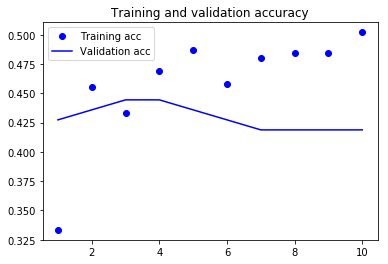

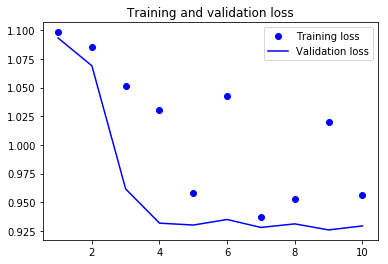

In [18]:
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()


